# 1000 m isobath contour for OM2-025

Code derived from the [Cosima Cookbook](https://github.com/COSIMA/cosima-recipes/blob/main/Recipes/Cross-contour_transport.ipynb)

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cmocean

from dask.distributed import Client

In [2]:
client = Client(threads_per_worker = 1)

In [3]:
session = cc.database.create_session('/home/156/wf4500/databases/access/OM2_25_DSW.db')

In [4]:
experiment = '025deg_jra55_ryf'
lat_range = slice(-82, -59)

In [5]:
%%time

yt_ocean = cc.querying.getvar(experiment, 'yt_ocean', session, n=1)
yt_ocean = yt_ocean.sel(yt_ocean = lat_range)

xt_ocean = cc.querying.getvar(experiment, 'xt_ocean', session, n=1)

yu_ocean = cc.querying.getvar(experiment, 'yu_ocean', session, n=1)
yu_ocean = yu_ocean.sel(yu_ocean = lat_range)

xu_ocean = cc.querying.getvar(experiment, 'xu_ocean', session, n=1)

CPU times: user 5.44 s, sys: 2.46 s, total: 7.9 s
Wall time: 48.2 s


In [6]:
if len(yt_ocean) != len(yu_ocean):
    print('help! y different size')

if yt_ocean.min('yt_ocean')> yu_ocean.min('yu_ocean'):
    print('help! wrong order')

if len(xt_ocean) != len(xu_ocean):
    print('help! x different size')

if xt_ocean.min('xt_ocean')> xu_ocean.min('xu_ocean'):
    print('help! x wrong order')

In [7]:
ht = cc.querying.getvar(experiment, 'ht', session, n=1).sel(yt_ocean = lat_range)

In [8]:
contour_depth = 1000 # metres

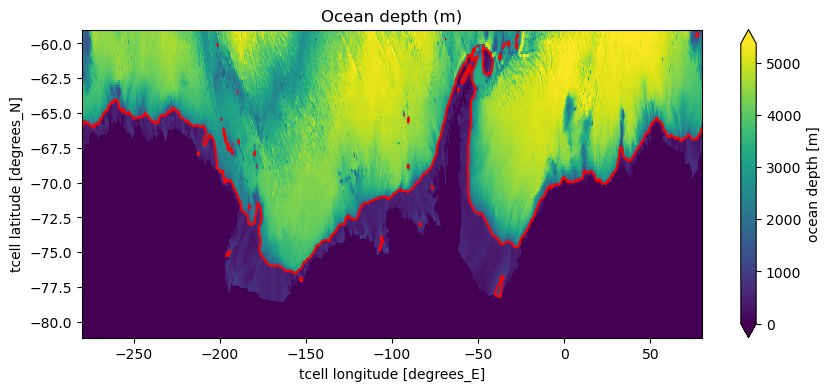

In [123]:
fig = plt.figure(figsize = (10, 4))

ht.plot(extend='both', cbar_kwargs={'label': "ocean depth [m]"})
ht.plot.contour(levels = [contour_depth], colors = 'r', linestyles = '-')
plt.title('Ocean depth (m)');

In [124]:
ht = ht.fillna(0).load()

In [125]:
grid_sel = 't'
x_var = xt_ocean
y_var = yt_ocean

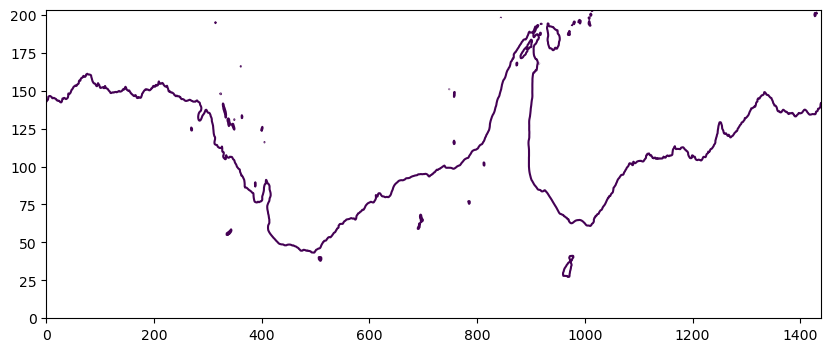

In [126]:
fig = plt.figure(figsize = (10, 4))
sc = plt.contour(ht, levels=[contour_depth])

path_vertices = (sc.get_paths()[0]).vertices
x_vertices = path_vertices[:, 0]
y_vertices = path_vertices[:, 1]

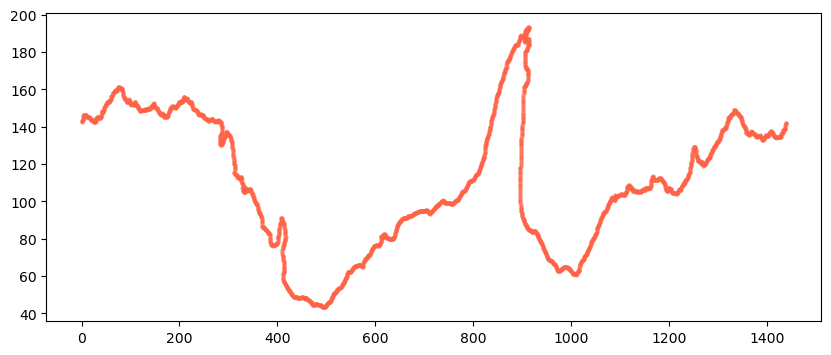

In [127]:
# For some reason we need a threshold of 1.01 here not just 1. Not sure why...
last_contour_index = np.where(np.abs(np.diff(x_vertices)) > 1.01)[0][0]

x_contour = x_vertices[:last_contour_index + 1]
y_contour = y_vertices[:last_contour_index + 1]

# Check desired contour looks right:
fig = plt.figure(figsize = (10, 4))
plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

In [128]:
x_contour = np.round(x_contour).astype(int)
y_contour = np.round(y_contour).astype(int)

# check that the difference between coords of contour never increase by more than 1:
if np.max(np.abs(np.diff(x_contour))) != 1:
    print('help! x_contour increases by more than 1 between coords.')

if np.max(np.abs(np.diff(y_contour))) != 1:
    print('help! y_contour increases by more than 1 between coords.')

In [129]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

In [130]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    x_contour = np.delete(x_contour, index)
    y_contour = np.delete(y_contour, index)

In [131]:
ht_contour = np.zeros(len(x_contour))

for ii in range(len(ht_contour)):
    ht_contour[ii] = ht[y_contour[ii], x_contour[ii]]

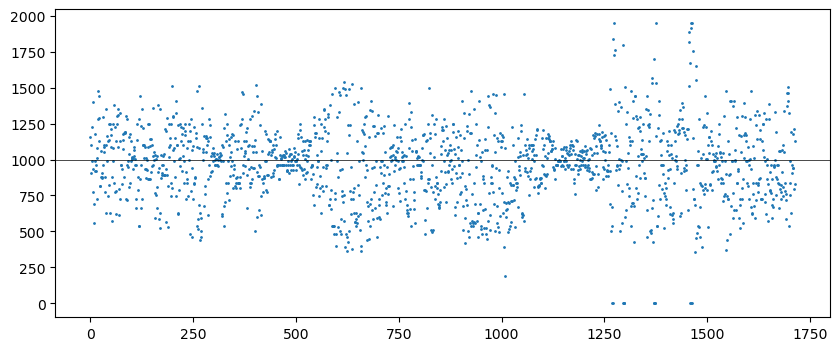

In [132]:
fig = plt.figure(figsize=(10, 4))

plt.plot(ht_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

In [133]:
# Number of grid points on the contour
num_points = len(x_contour)

In [134]:
# start numbering from 1 not 0:
contour_mask_numbered = np.arange(1, len(x_contour)+1)

In [135]:
contour_mask = xr.zeros_like(ht)

for ii in range(num_points):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]

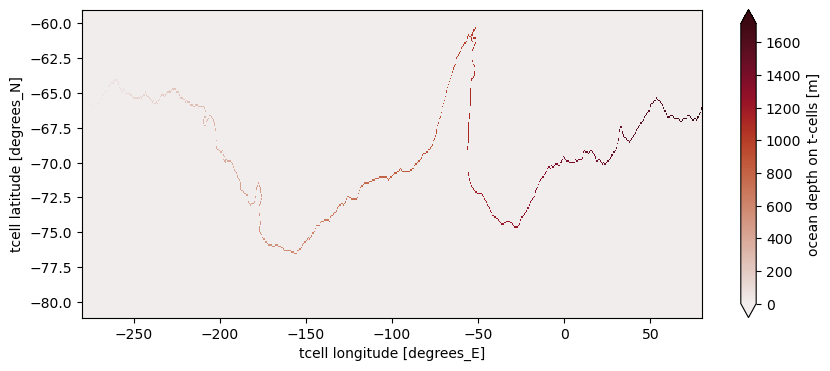

In [136]:
plt.figure(1, figsize=(10, 4))
contour_mask.plot(extend='both', cmap = cmocean.cm.amp);

In [137]:
%%time

mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

# from top left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

#from top right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

CPU times: user 4.89 s, sys: 61.5 ms, total: 4.95 s
Wall time: 4.89 s


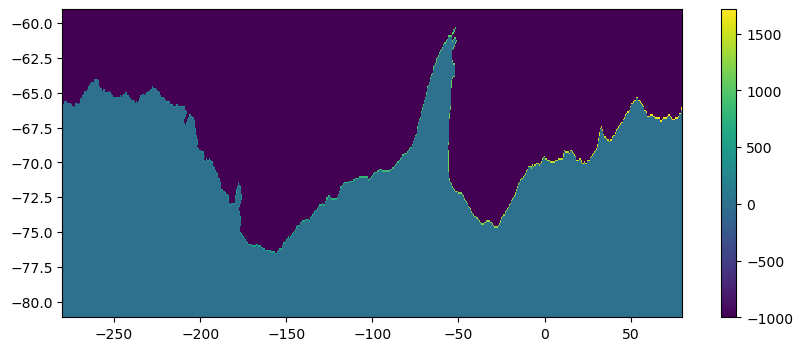

In [138]:
plt.figure(1, figsize=(10, 4))

plt.pcolormesh(contour_mask.xt_ocean, contour_mask.yt_ocean, contour_masked_above)
plt.colorbar();

In [139]:
%%time
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos:
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]

new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
    # if point below and point above are BOTH towards Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]==0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport[index_j, index_i] = -1        
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        mask_y_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1
    # if point to left and right BOTH toward Antarctica
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]==0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport[index_j, index_i] = -1        
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        mask_x_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2

CPU times: user 4.34 s, sys: 210 ms, total: 4.55 s
Wall time: 4.01 s


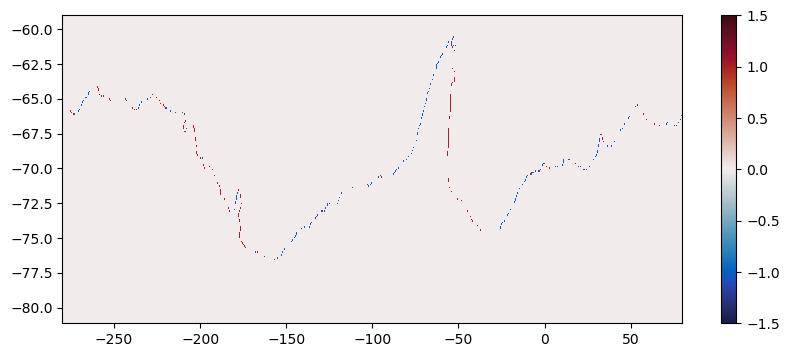

In [140]:
# Plot the mask for the x-transport:
plt.figure(1, figsize=(10, 4))

plt.pcolormesh(contour_mask.xt_ocean, contour_mask.yt_ocean, mask_x_transport,
               cmap=cmocean.cm.balance, vmin=-1.5, vmax=1.5)
plt.colorbar();

In [141]:
mask_x_transport = xr.DataArray(mask_x_transport,
                                coords = [yt_ocean, xu_ocean],
                                dims = ['latitude', 'longitude'])
mask_y_transport = xr.DataArray(mask_y_transport,
                                coords = [yu_ocean, xt_ocean],
                                dims = ['latitude', 'longitude'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered,
                                         coords = [yt_ocean, xu_ocean],
                                         dims = ['latitude', 'longitude'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered,
                                         coords = [yu_ocean, xt_ocean],
                                         dims = ['latitude', 'longitude'])

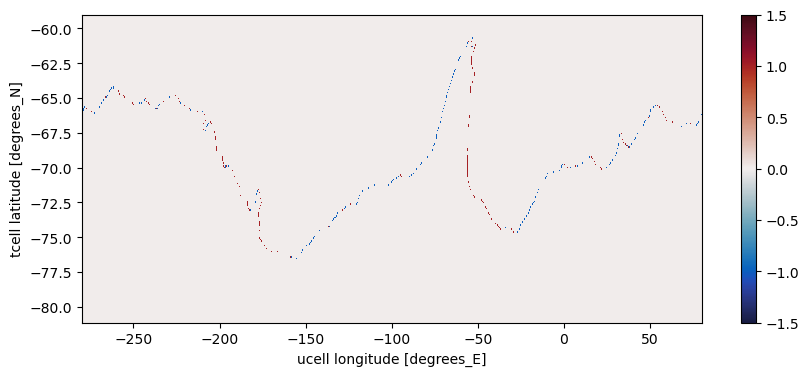

In [142]:
plt.figure(1, figsize=(10, 4))

mask_x_transport.plot(cmap=cmocean.cm.balance, vmin=-1.5, vmax=1.5);

In [143]:
# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['latitude', 'longitude'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['latitude', 'longitude'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

## Extracting values along contour

In [144]:
start_time = '1900-01-01'
end_time = '1900-12-31'
time_slice = slice(start_time, end_time)

ty_trans = cc.querying.getvar(experiment, 'ty_trans', session, start_time = start_time, end_time = end_time, chunks={})
ty_trans = ty_trans.sel(yu_ocean = lat_range, time = time_slice)

tx_trans = cc.querying.getvar(experiment, 'tx_trans', session, start_time = start_time, end_time = end_time, chunks={})
tx_trans = tx_trans.sel(yt_ocean = lat_range, time = time_slice)

ty_trans = ty_trans.rename({'yu_ocean': 'latitude', 'xt_ocean': 'longitude'})
tx_trans = tx_trans.rename({'yt_ocean': 'latitude', 'xu_ocean': 'longitude'})

In [145]:
%%time

# weighed time mean by month length
days_in_month = ty_trans.time.dt.days_in_month
days_in_year = 365

tx_trans = (tx_trans * days_in_month / days_in_year).sum('time')
tx_trans = tx_trans.load()

ty_trans = (ty_trans * days_in_month / days_in_year).sum('time')
ty_trans = ty_trans.load()

CPU times: user 5.82 s, sys: 1.83 s, total: 7.65 s
Wall time: 13.3 s


In [146]:
ρ0 = 1035 # kg/m^3

ty_trans = ty_trans * mask_y_transport / ρ0 # convert kg/s -> m^3/s
tx_trans = tx_trans * mask_x_transport / ρ0 # convert kg/s -> m^3/s

In [147]:
## We could also loop in time if we didn't want the time average. 
# In that case, initialise a data array and fill in data by looping in time.

# stack transports into 1d and drop any points not on contour:
x_transport_1d = tx_trans.stack(contour_index = ['latitude', 'longitude'])
x_transport_1d = x_transport_1d.where(mask_x_numbered_1d>0, drop = True)
y_transport_1d = ty_trans.stack(contour_index = ['latitude', 'longitude'])
y_transport_1d = y_transport_1d.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
vol_trans_across_contour = xr.concat((x_transport_1d, y_transport_1d), dim = 'contour_index')
vol_trans_across_contour = vol_trans_across_contour.sortby(contour_ordering)
vol_trans_across_contour.coords['contour_index'] = contour_index_array
vol_trans_across_contour = vol_trans_across_contour.load()

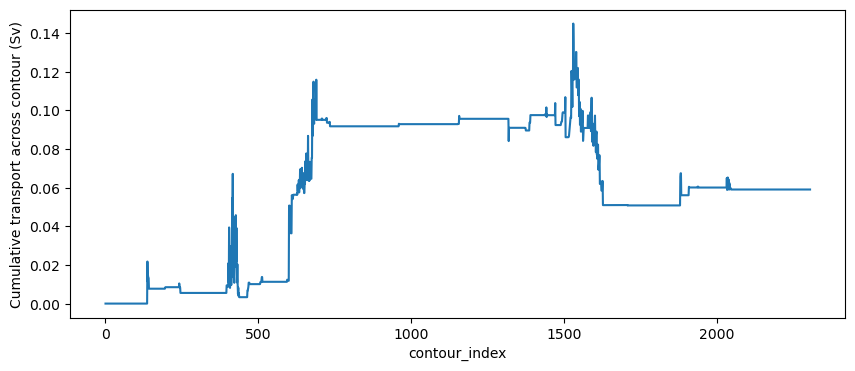

In [148]:
plt.figure(1, figsize=(10, 4))

(vol_trans_across_contour.sel(st_ocean=slice(800, 6000)).sum('st_ocean').cumsum('contour_index')/1e6).plot()
plt.ylabel('Cumulative transport across contour (Sv)');

In [149]:
contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.latitude.copy()
lon_along_contour = contour_ordering.longitude.copy()

contour_index_array = np.arange(1, len(contour_ordering)+1)

# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

In [150]:
from geopy import distance

num_points = len(lat_along_contour)
d_distance_along_contour = np.zeros((num_points))

for i in range(num_points-1):
    d_distance_along_contour[i+1] = distance.distance((lat_along_contour[i], lon_along_contour[i]), (lat_along_contour[i+1], lon_along_contour[i+1])).km

distance_along_contour = np.cumsum(d_distance_along_contour)

In [151]:
target_lons = [-280, -240, -180, -120, -60, 0, 6., 80]

distance_indices = np.zeros_like(target_lons)

for j, lon in enumerate(target_lons):
    distance_indices[j] = np.argmin(np.abs((lon_along_contour.values - lon)))

In [152]:
depth_to_integrate = 600 # m

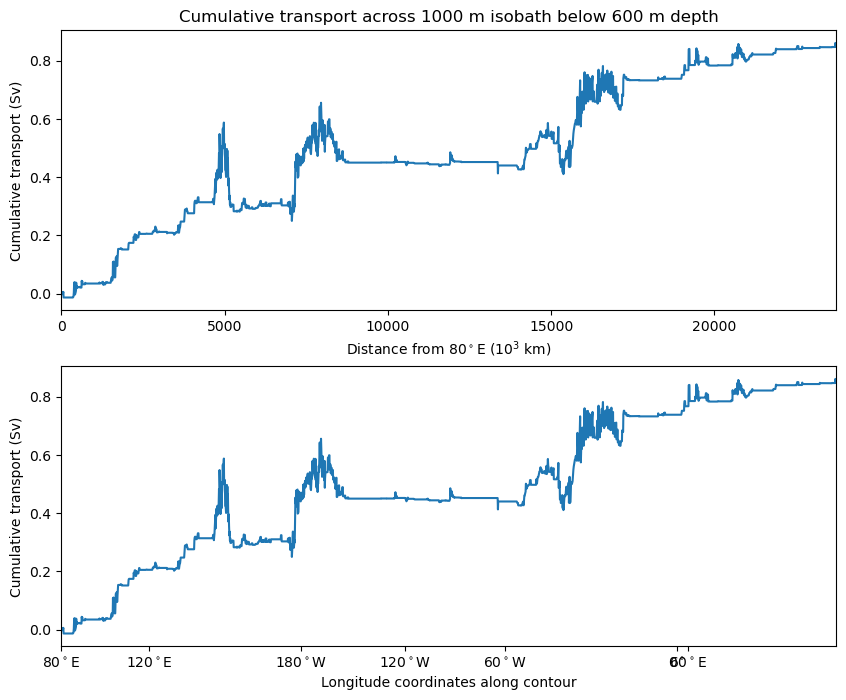

In [153]:
fig, axes = plt.subplots(nrows = 2, figsize = (10, 8))

# factor 1e-6 converts m^3/s -> Sv
axes[0].plot(distance_along_contour, (1e-6 * vol_trans_across_contour.sel(st_ocean = slice(depth_to_integrate, 6000)).sum('st_ocean').cumsum('contour_index')))

axes[0].set_ylabel('Cumulative transport (Sv)')
axes[0].set_xlabel('Distance from 80$^\circ$E (10$^3$ km)')
axes[0].set_xlim(0, distance_along_contour[-1])
axes[0].set_title(f'Cumulative transport across {contour_depth} m isobath below {depth_to_integrate} m depth')

# factor 1e-6 converts m^3/s -> Sv
axes[1].plot(distance_along_contour, (1e-6 * vol_trans_across_contour.sel(st_ocean = slice(depth_to_integrate, 6000)).sum('st_ocean').cumsum('contour_index')))

axes[1].set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes[1].set_xticklabels(('80$^\circ$E', '120$^\circ$E', '180$^\circ$W', '120$^\circ$W', '60$^\circ$W', '0$^\circ$', '60$^\circ$E'))
axes[1].set_xlim(0, distance_along_contour[-1])

axes[1].set_xlabel('Longitude coordinates along contour')
axes[1].set_ylabel('Cumulative transport (Sv)');

#### Saving contour definitions into a npz

In [154]:
np.savez('/g/data/ik11/users/wf4500/DSW_collaborative/sigma0_SWMT/OM2_025_1000m_isobath_contour.npz',
         contour_masked_above = contour_masked_above,distance_along_contour = distance_along_contour,\
                   contour_mask = contour_mask, contour_mask_numbered = contour_mask_numbered, lat_along_contour = lat_along_contour,\
                   lon_along_contour = lon_along_contour,mask_x_numbered_1d = mask_x_numbered_1d,\
                   mask_x_transport = mask_x_transport,mask_x_transport_numbered = mask_x_transport_numbered,\
                   mask_y_numbered_1d = mask_y_numbered_1d,mask_y_transport = mask_y_transport,\
         mask_y_transport_numbered = mask_y_transport_numbered,xu_ocean = xu_ocean,yu_ocean = yu_ocean)

#### Saving contour definitions into a netcdf

In [155]:
mask_x_numbered_1d.name = 'mask_x_numbered_1d'
mask_x_numbered_1d_tosave = mask_x_numbered_1d.rename({'contour_index':'longitude_x_1d'})
mask_x_numbered_1d_tosave['longitude_x_1d'] = mask_x_numbered_1d.longitude.values
mask_x_numbered_1d_2 = mask_x_numbered_1d_tosave.copy()
mask_x_numbered_1d_2.name = 'latitude_x_1d'
mask_x_numbered_1d_2.values = mask_x_numbered_1d.latitude.values
mask_x_numbered_1d_tosave = xr.merge([mask_x_numbered_1d_tosave,mask_x_numbered_1d_2])


In [156]:
mask_y_numbered_1d.name = 'mask_y_numbered_1d'
mask_y_numbered_1d_tosave = mask_y_numbered_1d.rename({'contour_index':'longitude_y_1d'})
mask_y_numbered_1d_tosave['longitude_y_1d'] = mask_y_numbered_1d.longitude.values
mask_y_numbered_1d_2 = mask_y_numbered_1d_tosave.copy()
mask_y_numbered_1d_2.name = 'latitude_y_1d'
mask_y_numbered_1d_2.values = mask_y_numbered_1d.latitude.values
mask_y_numbered_1d_tosave = xr.merge([mask_y_numbered_1d_tosave,mask_y_numbered_1d_2])


In [157]:
# when creating the fulld ataset, include:
    ##xu_ocean and yu_ocean   ##
    ##contour_mask
    ##contour_mask_numbered
    ##lat_along_contour
    ##lon_along_contour
    ##mask_x_numbered_1d
    ##mask_x_transport
    ##mask_x_transport_numbered
    ##mask_y_numbered_1d 
    ##mask_y_transport
    ##mask_y_transport_numbered


#first, let's convert everyhting into xarray
XR_contour_masked_above = xr.DataArray(data = contour_masked_above, coords = (yt_ocean,xt_ocean), name  = 'contour_masked_above')


#making shelf mask
shelf_mask = ((XR_contour_masked_above.where(XR_contour_masked_above>=0) * 0)+1)
shelf_mask.name = 'shelf_mask'
shelf_mask = shelf_mask.rename({'xt_ocean':'xm_ocean','yt_ocean':'ym_ocean'})
shelf_mask
# create the distance along contour variable
XR_distance_along_contour  = xr.DataArray(data = distance_along_contour, coords = (contour_ordering,), name  = 'distance_along_contour')


#renaming some arrays to join in the dataset
mask_x_numbered_1d.name = 'mask_x_numbered_1d'

mask_x_transport.name = 'mask_x_transport'
mask_x_transport_numbered.name = 'mask_x_transport_numbered'
mask_y_numbered_1d.name = 'mask_y_numbered_1d'
mask_y_numbered_1d = mask_y_numbered_1d.rename({'contour_index':'contour_index_y'})
mask_y_transport.name = 'mask_y_transport'
mask_y_transport_numbered.name = 'mask_y_transport_numbered'
xu_ocean.name = 'u_longitude'
yu_ocean.name = 'u_latitude'

#saving the Dataset
Dataset = xr.merge([XR_contour_masked_above,XR_distance_along_contour,shelf_mask,\
                   contour_mask, contour_mask_numbered, lat_along_contour,\
                   lon_along_contour,mask_x_numbered_1d_tosave,\
                   mask_x_transport.rename({'latitude':'yx_ocean','longitude':'xx_ocean'}),\
                   mask_x_transport_numbered.rename({'latitude':'yt_ocean','longitude':'xt_ocean'}),\
                   mask_y_numbered_1d_tosave,\
                   mask_y_transport.rename({'latitude':'yy_ocean','longitude':'xy_ocean'}),\
                   mask_y_transport_numbered.rename({'latitude':'yt_ocean','longitude':'xt_ocean'}),
                   xu_ocean,yu_ocean])

Dataset = Dataset.drop_vars(('geolon_t','geolat_t'))

#Let's save the dataset
Dataset.to_netcdf('/g/data/ik11/users/wf4500/DSW_collaborative/sigma0_SWMT/OM2_025_1000m_isobath_contour.nc')
Dataset

<xarray.Dataset> Size: 23MB
Dimensions:                    (yt_ocean: 408, xt_ocean: 2880,
                                contour_index: 2304, ym_ocean: 204,
                                xm_ocean: 1440, longitude_x_1d: 768,
                                yx_ocean: 204, xx_ocean: 1440,
                                longitude_y_1d: 1536, yy_ocean: 204,
                                xy_ocean: 1440, xu_ocean: 1440, yu_ocean: 204)
Coordinates: (12/13)
  * yt_ocean                   (yt_ocean) float64 3kB -81.08 -81.02 ... -59.01
  * xt_ocean                   (xt_ocean) float64 23kB -279.9 -279.8 ... 80.0
  * contour_index              (contour_index) float32 9kB 1.0 2.0 ... 2.304e+03
  * ym_ocean                   (ym_ocean) float64 2kB -81.08 -80.97 ... -59.07
  * xm_ocean                   (xm_ocean) float64 12kB -279.9 -279.6 ... 79.88
  * longitude_x_1d             (longitude_x_1d) float64 6kB -156.8 ... -52.75
    ...                         ...
  * xx_ocean                   (xx_ocean) float64 12kB -279.8 -279.5 ... 80.0
  * longitude_y_1d             (longitude_y_1d) float64 12kB -156.6 ... -52.88
  * yy_ocean                   (yy_ocean) float64 2kB -81.02 -80.92 ... -59.01
  * xy_ocean                   (xy_ocean) float64 12kB -279.9 -279.6 ... 79.88
  * xu_ocean                   (xu_ocean) float64 12kB -279.8 -279.5 ... 80.0
  * yu_ocean                   (yu_ocean) float64 2kB -81.02 -80.92 ... -59.01
Data variables: (12/16)
    contour_masked_above       (yt_ocean, xt_ocean) float32 5MB 0.0 nan ... nan
    distance_along_contour     (contour_index) float64 18kB 0.0 ... 2.373e+04
    shelf_mask                 (ym_ocean, xm_ocean) float32 1MB 1.0 1.0 ... nan
    ht                         (yt_ocean, xt_ocean) float32 5MB 0.0 nan ... nan
    latitude                   (contour_index) float64 18kB -66.03 ... -66.08
    longitude                  (contour_index) float64 18kB -279.9 ... 80.0
    ...                         ...
    mask_y_numbered_1d         (longitude_y_1d) float32 6kB 795.0 ... 1.379e+03
    latitude_y_1d              (longitude_y_1d) float64 12kB -76.59 ... -60.52
    mask_y_transport           (yy_ocean, xy_ocean) float32 1MB 0.0 0.0 ... 0.0
    mask_y_transport_numbered  (yt_ocean, xt_ocean) float32 5MB nan nan ... nan
    u_longitude                (xu_ocean) float64 12kB -279.8 -279.5 ... 80.0
    u_latitude                 (yu_ocean) float64 2kB -81.02 -80.92 ... -59.01